# Complete workflow to get info from GIS tools for hydrological modelling

Here we use birdy's WPS client to perform a catchment delineation, use the delineation to extract physical properties and prepare data for hydrological modelling, all using the Raven server.

In [70]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url, progress=True)

In [71]:
# MANIC: lonlat_coordinate="(-68.724444, 50.646667)"
# St-Lawrence I guess is "-75.724444, 44.646667"?  Returns 770 000 sq.km basin...
r_select = wps.shape_selection(location="-71.291660, 50.492758",lakes=True, aggregate_upstream=True)

The `location` parameter identifies the outlet of the watershed, and `aggregate_upstream` determines whether or not we want the service to return all upstream basins. 

In [72]:
# Get JSON Polygons of the delineated catchment
[features, upstream_basins] = r_select.get(asobj=True)
feature = features['features'][0] # TODO: Fix this server-side: What does this do? Why even have it?

Now that we have delineated a catchment, lets find the zonal statistics and other properties of the catchment.

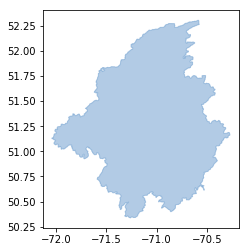

In [73]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt 

BLUE = '#6699cc'
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(feature['geometry'], fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()


In [74]:
# Here we are using the geojson file created on the server in the last step as the input value to a process 
# computing watershed properties. 
#crs=4326
#projected_crs=32198
[features, upstream_basins] = r_select.get()
resp = wps.shape_properties(shape=features)

Now, let's extract the data from the WPS service response:

In [75]:
[properties]=resp.get(asobj=True)
print(properties)

area=properties[0]['area']/1000000.0
longitude=properties[0]['centroid'][0]
latitude=properties[0]['centroid'][1]
gravelius=properties[0]['gravelius']
perimeter=properties[0]['perimeter']

shapeProperties={'area':area, 'longitude':longitude, 'latitude':latitude, 'gravelius':gravelius, 'perimeter':perimeter}


[{'id': 'USGS_HydroBASINS_lake_na_lev12.96929', 'COAST': 0, 'DIST_MAIN': 490.9, 'DIST_SINK': 490.9, 'ENDO': 0, 'HYBAS_ID': 7120270182, 'LAKE': 74, 'NEXT_DOWN': 7120270181, 'NEXT_SINK': 7120034330, 'ORDER': 1, 'PFAF_ID': 724089370000, 'SIDE': 'R', 'SORT': 96929, 'SUB_AREA': 14201.2, 'UP_AREA': 9419.6, 'area': 14058617253.170454, 'centroid': [-71.07253186896766, 51.278194003798866], 'perimeter': 935996.9220052982, 'gravelius': 2.2268870250753334}]


Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are differences between the two values. 

## PROBLEM: USING "FEATURE" INSTEAD OF "FEATURES" FAILS FOR THE WPS SERVICES. NOT SURE IF BUG OR...

Yeah, same problem server-side... 

In [77]:
# Use the geoserver to extract the land cover over the appropriate bounding box (automatic)
resp = wps.nalcms_zonal_stats(shape=features, select_all_touching=True,band=1, simple_categories=True)

#resp = wps.zonal_stats(features, str(raster), select_all_touching=True,return_geojson=False)

In [78]:
statistics=resp.get(asobj=True)

We now have the statistics from the NALCMS zonal_stats toolbox regarding the land use: 

In [79]:

statistics=statistics[0]['features'][0]['properties']
statistics


{'COAST': 0,
 'DIST_MAIN': 490.9,
 'DIST_SINK': 490.9,
 'ENDO': 0,
 'HYBAS_ID': 7120270182,
 'LAKE': 74,
 'NEXT_DOWN': 7120270181,
 'NEXT_SINK': 7120034330,
 'ORDER': 1,
 'PFAF_ID': 724089370000,
 'SIDE': 'R',
 'SORT': 96929,
 'SUB_AREA': 14201.2,
 'UP_AREA': 9419.6,
 'id': 'USGS_HydroBASINS_lake_na_lev12.96929',
 'Forest': 67823,
 'Shrubs': 1937016,
 'Grass': 80526,
 'Wetland': 186466,
 'Urban': 1986,
 'Water': 1943684,
 'count': 15857875,
 'nodata': 5.0}

Now, let's calculate the ratio of each land-use component. The "count" property is sometimes off so we recount the total ourselves:


In [80]:
# Extract each of the possible properties. Note that sometimes some properties are not present, 
# so we check them individually. Start by setting them to zero, we will update if the land use class is present.
Forest=0.
Shrubs=0.
Crops=0.
Urban=0.
Water=0.
Wetland=0.
Grass=0.
SnowIce=0.
                
# Update the land-use class according to the land use availability for the catchment.
if 'Forest' in statistics.keys():
    Forest=statistics['Forest']
if 'Shrubs' in statistics.keys():
    Shrubs=statistics['Shrubs']
if 'Grass' in statistics.keys():
    Grass=statistics['Grass']
if 'Wetland' in statistics.keys():
    Wetland=statistics['Wetland']
if 'Water' in statistics.keys():
    Water=statistics['Water']
if 'Urban' in statistics.keys():
    Urban=statistics['Urban']
if 'Crops' in statistics.keys():
    Crops=statistics['Crops']
if 'SnowIce' in statistics.keys():
    SnowIce=statistics['SnowIce']

# Calculate the total amount of land cover from these processes
Total=Forest+Shrubs+Grass+Wetland+Water+Urban+Crops+SnowIce

# Calculate the ratios
Forest=Forest/Total
Grass=Grass/Total
Wetland=Wetland/Total
Water=Water/Total
Urban=Urban/Total
Shrubs=Shrubs/Total
Crops=Crops/Total
SnowIce=SnowIce/Total    

# Store in dict format
landUse={'Forest':Forest, 'Grass':Grass, 'Wetland':Wetland, 'Water':Water,'Urban':Urban,'Shrubs':Shrubs,'Crops':Crops,'SnowIce':SnowIce}

Let's display these values for the user:


In [81]:
landUse

{'Forest': 0.016081323987830708,
 'Grass': 0.019093297191867885,
 'Wetland': 0.04421243764968876,
 'Water': 0.4608615386220418,
 'Urban': 0.0004708949683710804,
 'Shrubs': 0.4592805075801997,
 'Crops': 0.0,
 'SnowIce': 0.0}

The next step will be to collect terrain data, such as elevation, slope and aspect. We will do this using the Terrain_Analysis WPS service:

In [82]:
resp=wps.terrain_analysis(shape=features, select_all_touching=True,projected_crs=3978)

Now let's extract the properties from the WPS response. Use asobj=True to have Birdy preprocess the data and return the data directly.

In [83]:
[properties]=resp.get(asobj=True)

elevation=properties[0]['elevation']
slope=properties[0]['slope']
aspect=properties[0]['aspect']

terrain_data={'elevation':elevation, 'slope':slope,'aspect':aspect}

Finally, display all the extracted parameters for the user:

In [84]:
all_properties={**shapeProperties, **landUse, **terrain_data}
print(all_properties)

{'area': 14058.617253170454, 'longitude': -71.07253186896766, 'latitude': 51.278194003798866, 'gravelius': 2.2268870250753334, 'perimeter': 935996.9220052982, 'Forest': 0.016081323987830708, 'Grass': 0.019093297191867885, 'Wetland': 0.04421243764968876, 'Water': 0.4608615386220418, 'Urban': 0.0004708949683710804, 'Shrubs': 0.4592805075801997, 'Crops': 0.0, 'SnowIce': 0.0, 'elevation': 594.800152859848, 'slope': 2.9303332229214973, 'aspect': 186.10866554968163}


### There we go! We have extracted the contours of a watershed along with a series of hydrologically relevant properties, all from the coordinates of a single location (outlet)!